# Kerasによるニューラルネットワーク

##本チュートリアルではKerasを利用してニューラルネットワークの実装を確認，学習および評価を行います．環境としてはGoogle が提供する Google Colaboratory上でおこないます． GPU上で処理を行うため，colaboratoryの[ランタイム]->[ランタイムのタイプを変更]からハードウェアアクセラレータをGPUにしてください．

Kerasでニューラルネットワークを学習するために必要なモジュールや関数をインポートします．

In [0]:
import os
import numpy as np

import keras
from keras import backend as K
from keras.models import Sequential, load_model, Input
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

GPUが利用できるか確認します．

In [22]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


再帰型ニューラルネットワークを定義します．ここでは，LSTM層2層から構成されるネットワークとします．1層目のLSTM層は入力ベクトルが34次元，出力する特徴ベクトルが128次元です．2層目のLSTM層は入力ベクトルが128次元，出力が1次元です．どちらのLSTM層においてもバッチサイズ数は不定とします．

これらの各層の構成を定義します．まず，Sequential()で空のネットワークモデルを定義します．その後，LSTM層をmodel.add()によって順番に追加することで，ネットワークを定義します．作成したmodelを戻り値としています．

In [0]:
def create_model(time_window):
    model = Sequential()
    model.add(LSTM(128,
                   activation='sigmoid',
                   batch_input_shape=(None, time_window, 34),
                   return_sequences=True))
    model.add(LSTM(1,
                   activation='sigmoid',
                   batch_input_shape=(None, time_window, 128),
                   return_sequences=True))
    return model

次に学習データを準備します．まず，データをダウンロードし，zipファイルを解凍します．

In [24]:
!wget http://vision.cs.chubu.ac.jp/CVTutorial/SRC/ML_Lecture/SOLAR/data.zip
!unzip  data.zip

--2018-11-19 14:37:25--  http://vision.cs.chubu.ac.jp/CVTutorial/SRC/ML_Lecture/SOLAR/data.zip
Resolving vision.cs.chubu.ac.jp (vision.cs.chubu.ac.jp)... 157.110.46.70
Connecting to vision.cs.chubu.ac.jp (vision.cs.chubu.ac.jp)|157.110.46.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261264 (255K) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>] 255.14K   137KB/s    in 1.9s    

2018-11-19 14:37:27 (137 KB/s) - ‘data.zip.1’ saved [261264/261264]

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

KeyboardInterrupt: ignored

データがダウンロードできたか確認します．

In [25]:
!ls
!ls -R data/

data	    model-01.hdf5  model-04.hdf5  model-07.hdf5  model-10.hdf5
data.zip    model-02.hdf5  model-05.hdf5  model-08.hdf5  sample_data
data.zip.1  model-03.hdf5  model-06.hdf5  model-09.hdf5
data/:
test  train

data/test:
BEMS_RNN_test_data.npy	BEMS_RNN_test_labels.npy

data/train:
BEMS_RNN_train_data.npy  BEMS_RNN_train_labels.npy


ダウンロードしたデータを読み込みます．

In [0]:
x_train = np.load("./data/train/BEMS_RNN_train_data.npy")
y_train = np.load("./data/train/BEMS_RNN_train_labels.npy")
x_train = np.asarray(x_train[: -2])
y_train = np.asarray(y_train[2:])

x_test = np.load("./data/test/BEMS_RNN_test_data.npy")
y_test = np.load("./data/test/BEMS_RNN_test_labels.npy")
x_test = np.asarray(x_test[:-2])
y_test = np.asarray(y_test[2:])

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [27]:
print(x_train.shape, y_train.shape)

(49998, 34) (49998, 1)


学習・評価に使用するミニバッチを生成するクラスを定義します．このクラスでは，ネットワークへ入力するデータおよび教師ラベル，LSTMが一度に扱うデータの系列長（時間窓; time window），バッチサイズを指定し，クラスインスタンスを作成します．
その後，generate()を用いることで，学習およびテストに使用するデータを順次呼び出します．

In [0]:
class KerasBatchGenerator(object):

    def __init__(self, data, label, time_window, batch_size):
        self.data = data
        self.label = label
        self.time_window = time_window
        self.batch_size = batch_size
        self.current_idx = 0

        self.n_data = int(self.data.shape[0])
        self.n_feature = int(self.data.shape[1])
        self.n_label = int(self.label.shape[1])

    def generate(self):

        x = np.zeros((self.batch_size, self.time_window, self.n_feature))
        y = np.zeros((self.batch_size, self.time_window, 1))

        while True:
            for i in range(self.batch_size):

                if self.current_idx + self.time_window >= self.n_data:
                    self.current_idx = 0

                x[i, :, :] = self.data[self.current_idx:self.current_idx + self.time_window]
                y[i, :, :] = self.label[self.current_idx:self.current_idx + self.time_window]

                self.current_idx += self.time_window
            yield x, y

    def n_iteration(self):
        return self.n_data // (self.time_window * self.batch_size)

ネットワークモデルを作成します．
ネットワークが扱うデータのtime windowは200とします．
学習を行う際の最適化手法としてモーメンタムを持つ確率的勾配降下法（Stochastic Gradient Descent; SGD）を利用します．SGDには学習率)（learning rate; lr）を指定します．
その最適化手法と誤差関数を設定して，ネットワークモデルをコンパイルします．

In [0]:
time_window = 200

model = create_model(time_window)
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer)

作成したネットワークモデルの設定を確認します．

In [31]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 200, 128)          83456     
_________________________________________________________________
lstm_8 (LSTM)                (None, 200, 1)            520       
Total params: 83,976
Trainable params: 83,976
Non-trainable params: 0
_________________________________________________________________
None


ネットワークの学習を行います．
1回の誤差を算出するデータ数（ミニバッチサイズ）を20，学習エポック数を10とします．

ここでは，fit_generator()を用いた学習を行います．fit_generator()では，上記で定義したBatchGeneratorを用いて，データおよび教師ラベルを呼び出します．その後，データに対するネットワークの推論結果と教師ラベルから誤差を算出し，逆伝播することでネットワークの更新を行います．

この時，学習が1エポック終了するごとにテストデータに対する精度（誤差）を算出し，学習したネットワークモデルの保存を行います．

In [41]:
batch_size = 20
epoch = 10

train_generator = KerasBatchGenerator(x_train, y_train, time_window, batch_size)
test_generator = KerasBatchGenerator(x_test, y_test, time_window, batch_size)

checkpointer = ModelCheckpoint(filepath='./model-{epoch:02d}.hdf5', verbose=1)
model.fit_generator(train_generator.generate(),
                    x_train.shape[0] // (time_window * batch_size),
                    epoch,
                    validation_data=test_generator.generate(),
                    validation_steps=x_test.shape[0] // (time_window * batch_size),
                    callbacks=[checkpointer])

Epoch 1/10
12/12 [==============================] - 15s 1s/step - loss: 0.0566 - val_loss: 0.0309

Epoch 00001: saving model to ./model-01.hdf5
Epoch 2/10
12/12 [==============================] - 13s 1s/step - loss: 0.0663 - val_loss: 0.0301

Epoch 00002: saving model to ./model-02.hdf5
Epoch 3/10
12/12 [==============================] - 12s 1s/step - loss: 0.0426 - val_loss: 0.0270

Epoch 00003: saving model to ./model-03.hdf5
Epoch 4/10
12/12 [==============================] - 13s 1s/step - loss: 0.0521 - val_loss: 0.0280

Epoch 00004: saving model to ./model-04.hdf5
Epoch 5/10
12/12 [==============================] - 13s 1s/step - loss: 0.0512 - val_loss: 0.0272

Epoch 00005: saving model to ./model-05.hdf5
Epoch 6/10
12/12 [==============================] - 13s 1s/step - loss: 0.0523 - val_loss: 0.0256

Epoch 00006: saving model to ./model-06.hdf5
Epoch 7/10
12/12 [==============================] - 13s 1s/step - loss: 0.0518 - val_loss: 0.0233

Epoch 00007: saving model to ./model-

学習できたネットワークモデルを利用してテストデータに対する推論結果を確認します．

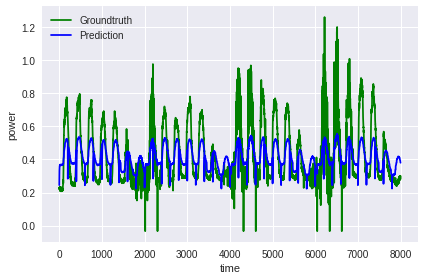

In [42]:
model = load_model("./model-10.hdf5")

example_test_generator = KerasBatchGenerator(x_test, y_test, time_window, batch_size)

true = []
pred = []
for i in range(x_test.shape[0] // (time_window * batch_size)):
    x, y = next(example_test_generator.generate())
    y_pred = model.predict(x, batch_size=batch_size)
    true.append(y.flatten())
    pred.append(y_pred.flatten())

plt.figure()
plt.plot(np.asarray(true).flatten(), 'g', label='Groundtruth')
plt.plot(np.asarray(pred).flatten(), 'b', label='Prediction')

plt.legend()
plt.xlabel('time')
plt.ylabel('power')
plt.tight_layout()
plt.show()

## 課題　
###以下の課題に取り組みましょう
1  GPUに対応したコードにしましょう

2  学習データをランダムに利用するように修正しましょう

3  ミニバッチ学習できるようにしましょう